<a href="https://colab.research.google.com/github/MikitaKiselev/MNIST_DS/blob/main/MNIST_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from torchvision.datasets import MNIST
import torch
import torchvision
from torchvision import transforms as tfs
from torchsummary import summary

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100,
                                          shuffle=True, num_workers=2)
valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=100,
                                         shuffle=False, num_workers=2)

Для начала решение через полносвязную нейронную сеть

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [ ]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =   torch.sum(preds == y_batch)
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8904166666666666
Loader: valid. Accuracy: 0.9358
Epoch: 2
Loader: train. Accuracy: 0.9511333333333334
Loader: valid. Accuracy: 0.9593
Epoch: 3
Loader: train. Accuracy: 0.96475
Loader: valid. Accuracy: 0.9686
Epoch: 4
Loader: train. Accuracy: 0.9718666666666667
Loader: valid. Accuracy: 0.9705
Epoch: 5
Loader: train. Accuracy: 0.9766
Loader: valid. Accuracy: 0.9741
Epoch: 6
Loader: train. Accuracy: 0.9795666666666667
Loader: valid. Accuracy: 0.9756
Epoch: 7
Loader: train. Accuracy: 0.9823
Loader: valid. Accuracy: 0.9774
Epoch: 8
Loader: train. Accuracy: 0.9838
Loader: valid. Accuracy: 0.9754
Epoch: 9
Loader: train. Accuracy: 0.9860333333333333
Loader: valid. Accuracy: 0.976
Epoch: 10
Loader: train. Accuracy: 0.9870833333333333
Loader: valid. Accuracy: 0.9753


Тестирование разных функций активации

In [ ]:
elu_accuracy = accuracy["valid"]

In [ ]:
print(accuracy)

{'train': [0.8904166666666666, 0.9511333333333334, 0.96475, 0.9718666666666667, 0.9766, 0.9795666666666667, 0.9823, 0.9838, 0.9860333333333333, 0.9870833333333333], 'valid': [0.9358, 0.9593, 0.9686, 0.9705, 0.9741, 0.9756, 0.9774, 0.9754, 0.976, 0.9753]}


In [ ]:
activation = nn.ELU

def test_activation_function(activation):
    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct =   torch.sum(preds == y_batch)
                all =  len(y_batch)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]

In [ ]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)
print("plain_accuracy:",plain_accuracy)
print("relu_accuracy:",relu_accuracy)
print("leaky_relu_accuracy:",leaky_relu_accuracy)

plain_accuracy: [0.899, 0.9121, 0.9091, 0.9103, 0.9119, 0.9102, 0.9136, 0.9107, 0.901, 0.9175]
relu_accuracy: [0.9311, 0.9557, 0.9622, 0.9639, 0.9691, 0.9707, 0.9703, 0.9734, 0.9769, 0.9758]
leaky_relu_accuracy: [0.9248, 0.9537, 0.9625, 0.9677, 0.9641, 0.9615, 0.9724, 0.9692, 0.9677, 0.9714]


Построим график accuracy/epoch для каждой функции активации.

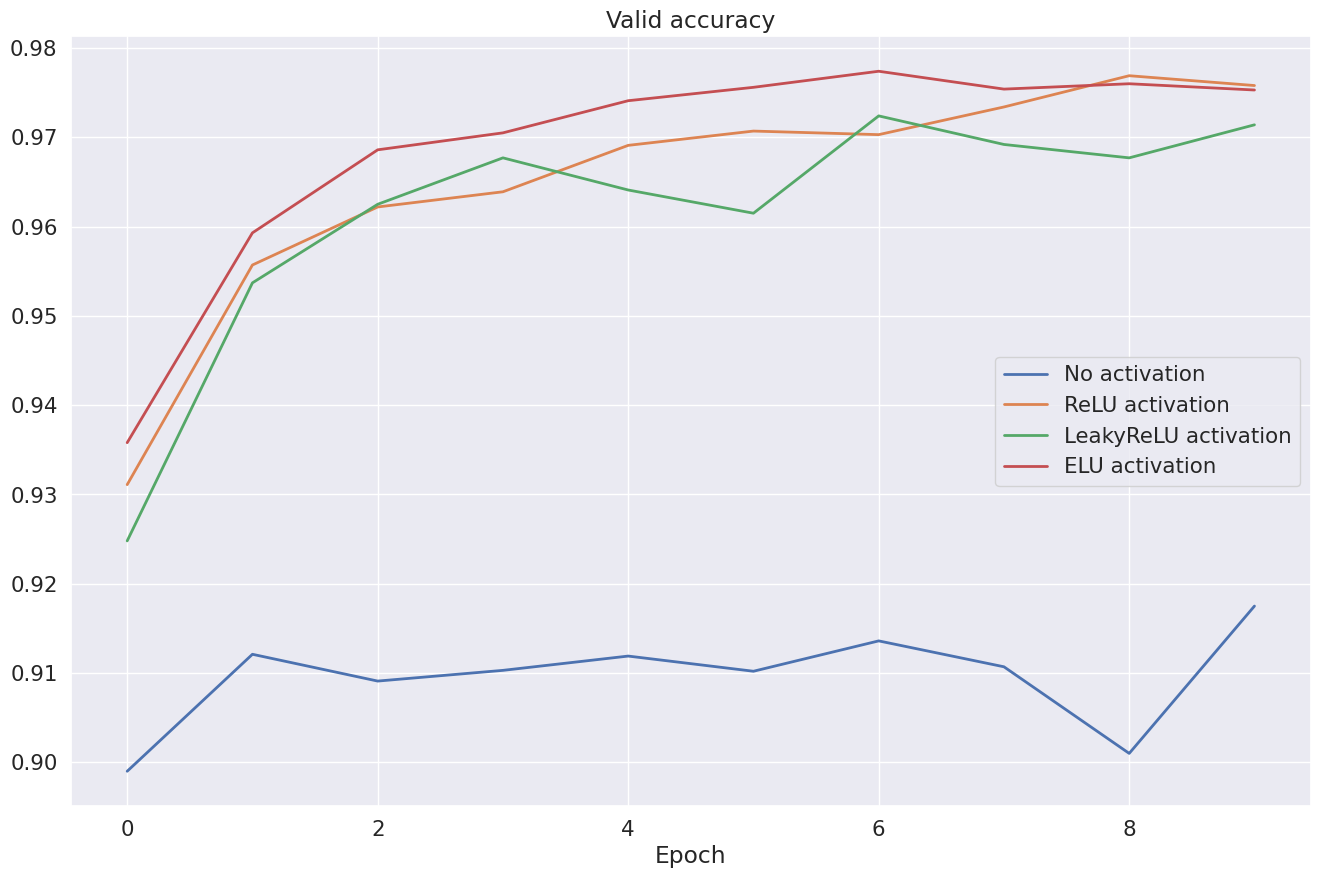

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

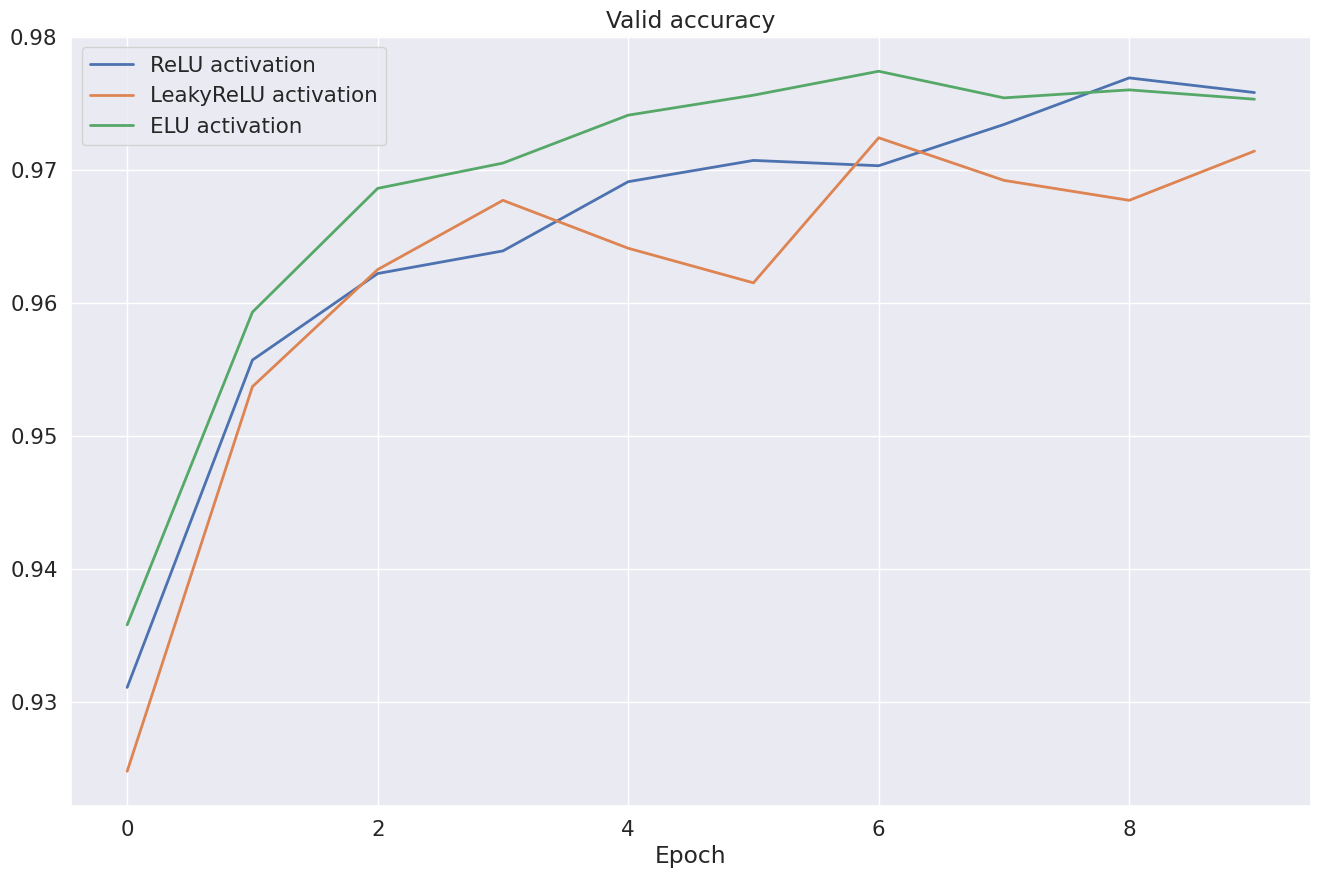

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

Решение через свёрточную нейронную сеть

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 5 * 5 * 16)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =   torch.sum(preds == y_batch)
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9016666666666666
Loader: valid. Accuracy: 0.9731
Epoch: 2
Loader: train. Accuracy: 0.9735166666666667
Loader: valid. Accuracy: 0.9798
Epoch: 3
Loader: train. Accuracy: 0.9817666666666667
Loader: valid. Accuracy: 0.9829
Epoch: 4
Loader: train. Accuracy: 0.98565
Loader: valid. Accuracy: 0.9854
Epoch: 5
Loader: train. Accuracy: 0.9882166666666666
Loader: valid. Accuracy: 0.9859
Epoch: 6
Loader: train. Accuracy: 0.99075
Loader: valid. Accuracy: 0.9888
Epoch: 7
Loader: train. Accuracy: 0.9913666666666666
Loader: valid. Accuracy: 0.988
Epoch: 8
Loader: train. Accuracy: 0.9928
Loader: valid. Accuracy: 0.9862
Epoch: 9
Loader: train. Accuracy: 0.99385
Loader: valid. Accuracy: 0.988
Epoch: 10
Loader: train. Accuracy: 0.9943
Loader: valid. Accuracy: 0.9868


In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

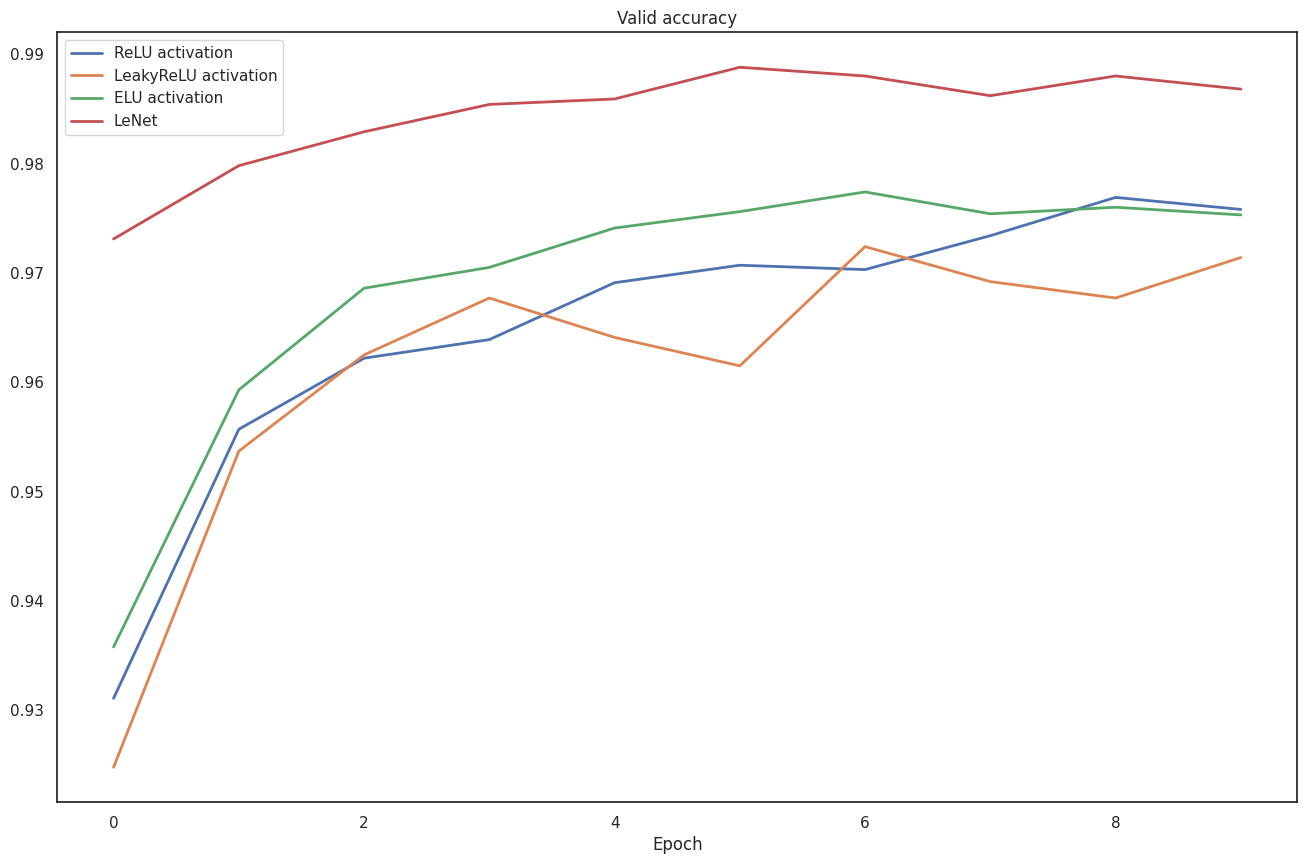

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
lenet_accuracy[-1]

0.9868